# CPSC 330 hw8

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import HuberRegressor, Ridge
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

## Submission Instructions
rubric={points:5}

Follow the [homework submission instructions](https://github.students.cs.ubc.ca/cpsc330-2019w-t2/home/blob/master/docs/homework_instructions.md). 

Furthermore, this assignment has an **additional submission requirement** outlined in Exercise 3.

### ANSWER

k0b0b and z5p0b worked on all the exercises together.

### END ANSWER

## Dataset

Choose one of the following datasets:

| Description | Where it's from | Type of problem |
|------------|------------------|-----------------|
| Movie reviews |  lecture 5 | language data + binary classification
| Adult census |  lecture 7 | binary classification
| House prices |  lecture 9 | regression
| Amazon product ratings |  lecture 15 | unsupervised / nearest neighbours
| Rain in Australia | lecture 16 | time series + binary classification
| Churn prediction | lecture 17 | survival analysis
| New York City Airbnb listings |  hw5 | regression
| Donald Trump's tweets |  hw6 | language data, regression
| Avocado prices |  hw7 | time series + regression
| Another dataset of your chosing | ? | ? |

**IMPORTANT NOTE:** If you are using one of the course datasets, you are welcome to reuse code from the course: lecture code, my homework solution code, your homework solution code, etc. The idea is to reduce the time spent on writing code so that you can focus on the communication aspect. If you reuse code, please make a brief note of it explaining where you got the code from.

If you choose the last option ("Another dataset") then the above will not apply, of course. So, the last option would potentially be a lot more work if you are starting from scratch, but I wanted to give you the option in case you really want to, or in case you have a personal project with code already written. If you choose this option and you incorporate code that was written by someone else, you MUST cite this code. 

You are also welcome to use one of the course datasets but focus on a different problem, e.g. binary classification of whether avocado price increased vs. decreased in the last week, or try to predict a different column of a dataset, etc. Just make sure to clearly state what you're doing.

### ANSWER

We have re-used the code from our hw5 for Exercise 2, and re-used the code from Lecture 22 for Exercise 4. 

### END ANSWER

## Exercise 1
rubric={points:5}

For your dataset, describe your goal (e.g. what you are trying to predict). Then, describe a (possibly fictional) scenario where someone in the real world is interested in this task and why it is useful to them. What is the **decision** that ML is going to help make (see lecture 21) and what are the alternatives?

Max 1 paragraph total.

### ANSWER

For this assignment, we have chosen the `New York City Airbnb listings` dataset. Our goal is to predict the number of `reviews_per_month` from available features as a proxy for a listing's popularity. This prediction will aid Airbnb in creating a guideline / user guide for hosts to create a better appealing listing. Furthermore, this prediction can also be useful to Airbnb hosts for verifying if their property is competitive enough to make a decent profit. If not, they can modify their listings by looking at the important features. Machine Learning will help decide how popular/review-worthy a given posting is. For instance, the alternatives would be one review, ten reviews, hundred reviews and so on. In addition, Machine Learning will assist in deciding whether to post the listing or not. In this case, the alternatives would be either to yes, post the listing, or no, not post the listing.

### END ANSWER

## Exercise 2
rubric={points:10}

Build a model for your chosen problem. Your work must involve the following elements:

- Exploratory outlier detection. 
- Preprocessing.
- Try some models includng, at least, the 3 steps discussed in lecture 20:
    1. `DummyRegressor` or `DummyClassifer`
    2. `HuberRegressor` or `LogisticRegression`
    3. `CatBoostRegressor` or `CatBoostClassifier`
- Hyperparameter tuning.

Note: for the outlier detection, if you are using a dataset from lecture, please do not do not exactly the same thing that was done in lecture 19. For example, consider a scatter plot of two features or look at a different feature than what we did in lecture.

Note: if you have trouble installing CatBoost you are welcome to substitute in XGBoost or LightGBM instead. Hopefully one of them will be easy to install. 

Note: you're not required to use the "proper handling of categorical features" in CatBoost, though it would be fun if you do!

Note: remember, you're allowed to reuse code from the course! My intention is that you shouldn't spend a huge amount of time on this exercise. Maybe 1 hour?

## Answer

In [4]:
# Load and split the data
df = pd.read_csv('AB_NYC_2019.csv')
df_train, df_test = train_test_split(df, test_size=0.1, random_state=123)
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=123)

Item with highest review is 58.5
Item with lowest non-zero is 0.01
Items with 0 reviews 6840
Items with > 0 reviews 33003


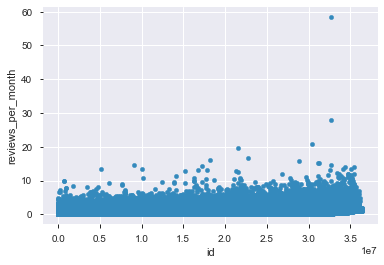

In [5]:
# Outlier Detection
df_train.plot.scatter(x="id", y="reviews_per_month");
print("Item with highest review is", df_train["reviews_per_month"].max())
print("Item with lowest non-zero is", df_train["reviews_per_month"].min())
print("Items with 0 reviews %d" % df_train["reviews_per_month"].isnull().sum())
print("Items with > 0 reviews %d" % np.count_nonzero(df_train["reviews_per_month"]))

There seems to one outlier with 58.5 reviews per month. We'll remove that.

In [6]:
df_train = df_train[df_train["reviews_per_month"] != 58.5]
print("Item with highest review is now", df_train["reviews_per_month"].max())

Item with highest review is now 27.95


In [7]:
# Preprocessing

# 1. Split out y values
target_name = 'reviews_per_month'
y_train = df_train[target_name].fillna(value=0)
y_valid = df_valid[target_name].fillna(value=0)
y_test  = df_test[target_name].fillna(value=0)

# we want to process y log

# 2. Transform x values: fit on train, transform on train, valid and test
categorical_features = ['neighbourhood', 'neighbourhood_group', 'room_type']
drop_features        = ['id', 'host_id', 'host_name', 'last_review', 'number_of_reviews'] # drop number_of_reviews because it's too similar to y
numeric_features     = ['latitude', 'longitude', 'price', 'minimum_nights', 'calculated_host_listings_count', 'availability_365']

transformers=[
    ('scale',  StandardScaler(), numeric_features),
    ('ohe',    OneHotEncoder(drop='first', sparse=False), categorical_features[1:]),
    ('ohe-nodrop', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features[:1])]

preprocessor = ColumnTransformer(transformers=transformers)
preprocessor.fit(df_train);
categorical_columns = list(preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features[1:])) + list(preprocessor.named_transformers_['ohe-nodrop'].get_feature_names(categorical_features[:1]))
new_columns = numeric_features + categorical_columns

X_train = pd.DataFrame(preprocessor.transform(df_train), index=df_train.index, columns=new_columns)
X_valid = pd.DataFrame(preprocessor.transform(df_valid), index=df_valid.index, columns=new_columns)
X_test  = pd.DataFrame(preprocessor.transform(df_test),  index=df_test.index,  columns=new_columns)


X_train.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,...,neighbourhood_West Village,neighbourhood_Westchester Square,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodside
36323,0.207865,1.643896,-0.524472,1.033278,-0.005967,-0.810505,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14968,1.905088,0.201041,-0.351297,-0.288490,-0.186444,-0.856140,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
691,0.311317,-1.081761,2.563110,-0.241284,-0.186444,1.889549,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21454,-1.144337,4.059799,-0.393535,-0.288490,-0.096206,-0.217254,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1015,-0.656795,0.176450,-0.245702,-0.099666,-0.186444,-0.856140,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# name might have useful info, we can vectorize it and add to our features

df_train.fillna({"name":""}, inplace=True)
df_valid.fillna({"name":""}, inplace=True)
df_test.fillna({"name":""}, inplace=True)

# vectorize with 100 features
count_vec = CountVectorizer(max_features=100, stop_words='english')
count_vec.fit(df_train['name']);
word_feature_names = ['name_' + word for word in count_vec.get_feature_names()]
X_train_name = pd.DataFrame(data=count_vec.transform(df_train["name"]).toarray(), columns=word_feature_names, index=X_train.index)
X_valid_name = pd.DataFrame(data=count_vec.transform(df_valid["name"]).toarray(), columns=word_feature_names, index=X_valid.index)
X_test_name  = pd.DataFrame(data=count_vec.transform(df_test["name"]).toarray(),  columns=word_feature_names, index=X_test.index)

X_train = pd.concat((X_train, X_train_name), axis=1)
X_valid = pd.concat((X_valid, X_valid_name), axis=1)
X_test  = pd.concat((X_test, X_test_name),   axis=1)

X_train.columns[X_train.columns.str.startswith("neighbourhood")]

C:\Users\kessr\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Index(['neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
       'neighbourhood_Allerton', 'neighbourhood_Arden Heights',
       'neighbourhood_Arrochar', 'neighbourhood_Arverne',
       'neighbourhood_Astoria', 'neighbourhood_Bath Beach',
       ...
       'neighbourhood_West Village', 'neighbourhood_Westchester Square',
       'neighbourhood_Whitestone', 'neighbourhood_Williamsbridge',
       'neighbourhood_Williamsburg', 'neighbourhood_Willowbrook',
       'neighbourhood_Windsor Terrace', 'neighbourhood_Woodhaven',
       'neighbourhood_Woodlawn', 'neighbourhood_Woodside'],
      dtype='object', length=222)

In [9]:
# we perform log on the y values because we care about the relative values
y_train_log = np.log(1 + y_train)
y_valid_log = np.log(1 + y_valid)
y_test_log  = np.log(1 + y_test)

In [8]:
# Models

# 1. Dummy Regressor
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train_log)

print('Train accuracy: %0.3f' % dummy.score(X_train, y_train_log))
print('Valid accuracy: %0.3f' % dummy.score(X_valid, y_valid_log))

Train accuracy: 0.000
Valid accuracy: -0.000


In [9]:
# 2. Huber Regressor
huber = HuberRegressor()
huber.fit(X_train, y_train_log)

print('Train accuracy: %0.3f' % huber.score(X_train, y_train_log))
print('Valid accuracy: %0.3f' % huber.score(X_valid, y_valid_log))

Train accuracy: 0.122
Valid accuracy: 0.098


In [10]:
# 3. CatBoostRegressor
cat = CatBoostRegressor()
cat.fit(X_train, y_train_log, verbose=100);

Learning rate set to 0.072728
0:	learn: 0.5650627	total: 57.7ms	remaining: 57.7s
100:	learn: 0.4378892	total: 1.21s	remaining: 10.8s
200:	learn: 0.4262050	total: 2.33s	remaining: 9.26s
300:	learn: 0.4192441	total: 3.25s	remaining: 7.54s
400:	learn: 0.4133196	total: 4.17s	remaining: 6.22s
500:	learn: 0.4085494	total: 5.08s	remaining: 5.06s
600:	learn: 0.4044189	total: 6s	remaining: 3.98s
700:	learn: 0.4002932	total: 6.98s	remaining: 2.98s
800:	learn: 0.3965300	total: 7.92s	remaining: 1.97s
900:	learn: 0.3932607	total: 8.79s	remaining: 965ms
999:	learn: 0.3898707	total: 9.66s	remaining: 0us


In [11]:
print('Training accuracy: %0.3f' % cat.score(X_train, y_train_log))
print('Validation accuracy: %0.3f' % cat.score(X_valid, y_valid_log))

Training accuracy: 0.546
Validation accuracy: 0.460


In [24]:
# 4. RandomForestRegressor
rf = RandomForestRegressor(random_state=123)
rf.fit(X_train, y_train_log);

C:\Users\kessr\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [26]:
print('Training accuracy: %0.3f' % rf.score(X_train, y_train_log))
print('Validation accuracy: %0.3f' % rf.score(X_valid, y_valid_log))

Training accuracy: 0.892
Validation accuracy: 0.402


In [12]:
X_train_valid = pd.concat((X_train, X_valid))
y_train_valid_log = pd.concat((y_train_log, y_valid_log))

In [13]:
parameters = {'max_depth'     : scipy.stats.randint(low=5, high=16),
              'learning_rate' : scipy.stats.uniform(),
              'iterations'    : scipy.stats.randint(low=10, high=100)
             }

cat_search = RandomizedSearchCV(CatBoostRegressor(random_state=123), param_distributions = parameters, return_train_score=True, n_iter=20, cv=3, random_state=123, n_jobs=-1)
cat_search.fit(X_train_valid, y_train_valid_log);

cat_cv_results = pd.DataFrame(cat_search.cv_results_)[['mean_test_score', 'param_max_depth', 'mean_train_score', 'rank_test_score']].set_index("rank_test_score").sort_index()
print("Training  score", cat_cv_results.iloc[0]["mean_train_score"])
print("Cross-val score", cat_cv_results.iloc[0]["mean_test_score"])

0:	learn: 0.5368826	total: 106ms	remaining: 7.93s
1:	learn: 0.5096189	total: 220ms	remaining: 8.13s
2:	learn: 0.4884242	total: 340ms	remaining: 8.27s
3:	learn: 0.4758229	total: 490ms	remaining: 8.81s
4:	learn: 0.4660246	total: 626ms	remaining: 8.89s
5:	learn: 0.4603809	total: 757ms	remaining: 8.83s
6:	learn: 0.4535435	total: 881ms	remaining: 8.69s
7:	learn: 0.4490355	total: 1.01s	remaining: 8.58s
8:	learn: 0.4448666	total: 1.13s	remaining: 8.44s
9:	learn: 0.4423136	total: 1.24s	remaining: 8.17s
10:	learn: 0.4388995	total: 1.34s	remaining: 7.95s
11:	learn: 0.4362134	total: 1.49s	remaining: 7.94s
12:	learn: 0.4350465	total: 1.63s	remaining: 7.89s
13:	learn: 0.4331585	total: 1.75s	remaining: 7.76s
14:	learn: 0.4322052	total: 1.88s	remaining: 7.64s
15:	learn: 0.4305106	total: 1.99s	remaining: 7.45s
16:	learn: 0.4293964	total: 2.09s	remaining: 7.26s
17:	learn: 0.4281577	total: 2.2s	remaining: 7.1s
18:	learn: 0.4269559	total: 2.33s	remaining: 6.99s
19:	learn: 0.4260152	total: 2.48s	remaining

In [13]:
rf_param_dist = {
              "n_estimators"     : scipy.stats.randint(low=5, high=100),
              "max_depth"        : scipy.stats.randint(low=5, high=30),
              "max_features"     : scipy.stats.randint(low=5, high=30)
             }

rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=123), rf_param_dist, return_train_score=True, verbose=1, n_iter=20, cv=3, random_state=123, n_jobs=-1)
rf_search.fit(X_train_valid, y_train_valid_log);
rf_search.best_params_

rf_cv_results = pd.DataFrame(rf_search.cv_results_)[['mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_max_features', 'mean_train_score', 'rank_test_score']].set_index("rank_test_score").sort_index()
print("Training  accuracy", rf_cv_results.iloc[0]["mean_train_score"])
print("Validation accuracy", rf_cv_results.iloc[0]["mean_test_score"])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.0min finished


Training  accuracy 0.6246219505783939
Validation accuracy 0.418489636049741


In [15]:
cat_search.best_params_

{'iterations': 76, 'learning_rate': 0.2268514535642031, 'max_depth': 11}

In [17]:
rf_search.best_params_

{'max_depth': 22, 'max_features': 28, 'n_estimators': 72}

<br/><br/>
It seems like out of all the models, `CatBoostRegressor` gives the best validation accuracy of 0.46.

## End Answer

## Exercise 3
rubric={points:40}

In a **separate Jupyter notebook from this one**, write up your results in a "blog post" or report format that is aimed at a **potentially non-technical decision-maker or stakeholder**. Your post must include the following elements (not necessarily in this order):

- Describe the problem/decision.
- Describing the dataset (the raw data and/or some EDA).
- Describing the model.
- Describing your results, both quantitatively and qualitatively. Make sure to refer to the original problem/decision.
- A section on caveats, describing at least 3 reasons why your results might be incorrect, misleading, overconfident, or otherwise problematic. Make reference to your specific dataset, model, approach, etc. To check that your reasons are specific enough, make sure they would not make sense, if left unchanged, to most students' submissions; for example, do not just say "overfitting" without explaining why you might be worried about overfitting in your specific case.
- At least 2 visualizations.

A reasonable length for your entire post would be **1000 words**. The maximum allowed is 2000 words.

**SUBMISSION REQUIREMENT:** Upload your blog post to your homework repository. Then, put a clickable link to your blog post in your homework repository README. Thus, your README should now have two links: one to this document and one to your blog post. Please test both of them out in your web browser and make sure that both of them work as intended.

Note: Exercise 2 is separate from this because we want to see all your code in Exercise 2. Your blog post should have a lot less code than Exercise 2, if any.

#### A note on plagiarism

- In this assignment, you are allowed to include code that was not written by you, but you must cite the source.
- In this assignment, you are **NOT** allowed to include text or visualizations that were not written/created by you.

If you are in any doubt as to what constitutes plagiarism, please just ask.

For more information see the [UBC Academic Misconduct policies](http://www.calendar.ubc.ca/vancouver/index.cfm?tree=3,54,111,959).

### ANSWER

The blog post `blogPost.ipynb` is located at the repository root. Its link is also in the `README.md` file.

### END ANSWER

## Exercise 4
rubric={points:10}

- Describe one effective communication technique (lecture 21/22) that you used in your post, or an aspect of the post that you are particularly satisfied with.
- Describe an aspect of your post that you are not quite satisfied with, or one way in which your post could still be improved.

Max 1 paragraph total.

### ANSWER

* We are satisfied with the use of real-world analogies in introducing the problem and the caveats (bottom-up explanations)
* We are not quite satisfied with the data preparation and model description section, since we just quickly glanced over the approaches we tried in a top-down manner. We also included some terminologies without providing an easy-to-grasp explanation, so the readers without any technical background might be confused when reading these sections. However, explaining the inner workings of all the models and hyperparameter tuning would be too much for one blog post. If we were writing a longer explanation, we would have invested more time in breaking down all the concepts for our readers.

### END ANSWER

## Exercise 5
rubric={points:15}

Create a visualization that is different from the ones in your report, which was crafted intentionally to mislead or misrepresent the results of your analysis. Include your visualization, and the code that generated it, here. Then, explain what you did: 

- What is the incorrect interpretation that your visualization is trying to show? 
- What is the correct interpretation?
- How would you fix your visualization?

Max 1 paragraph total.

### ANSWER

In [28]:
import matplotlib.pyplot as plt

max_depth_values = [5, 10, 15]

In [23]:
score_rf_train = list()
score_rf_test = list()
score_cat_train = list()
score_cat_test = list()

for max_depth in max_depth_values:
    print(max_depth)
    rf = RandomForestRegressor(max_depth=max_depth, random_state=123).fit(X_train, y_train_log)
    score_rf_train.append(rf.score(X_train, y_train_log))
    score_rf_test.append(rf.score(X_test, y_test_log))
    
    cat = CatBoostRegressor(max_depth=max_depth, random_state=123).fit(X_train, y_train_log)
    score_cat_train.append(cat.score(X_train, y_train_log))
    score_cat_test.append(cat.score(X_test, y_test_log))

5


C:\Users\kessr\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Learning rate set to 0.072728
0:	learn: 0.5652870	total: 7.49ms	remaining: 7.49s
1:	learn: 0.5539169	total: 14.7ms	remaining: 7.33s
2:	learn: 0.5428216	total: 22.9ms	remaining: 7.62s
3:	learn: 0.5339921	total: 29.8ms	remaining: 7.41s
4:	learn: 0.5256742	total: 36.7ms	remaining: 7.3s
5:	learn: 0.5181872	total: 43.9ms	remaining: 7.28s
6:	learn: 0.5114191	total: 51.7ms	remaining: 7.33s
7:	learn: 0.5055601	total: 58.9ms	remaining: 7.31s
8:	learn: 0.5006307	total: 66.4ms	remaining: 7.31s
9:	learn: 0.4960004	total: 73.7ms	remaining: 7.3s
10:	learn: 0.4919225	total: 81.1ms	remaining: 7.29s
11:	learn: 0.4886894	total: 88.1ms	remaining: 7.25s
12:	learn: 0.4856142	total: 95.2ms	remaining: 7.23s
13:	learn: 0.4824122	total: 103ms	remaining: 7.23s
14:	learn: 0.4801287	total: 110ms	remaining: 7.21s
15:	learn: 0.4773897	total: 118ms	remaining: 7.26s
16:	learn: 0.4751355	total: 125ms	remaining: 7.24s
17:	learn: 0.4731992	total: 133ms	remaining: 7.24s
18:	learn: 0.4715947	total: 140ms	remaining: 7.22s


172:	learn: 0.4328709	total: 1.44s	remaining: 6.88s
173:	learn: 0.4327575	total: 1.45s	remaining: 6.87s
174:	learn: 0.4327249	total: 1.46s	remaining: 6.86s
175:	learn: 0.4326659	total: 1.47s	remaining: 6.86s
176:	learn: 0.4325587	total: 1.47s	remaining: 6.85s
177:	learn: 0.4324647	total: 1.48s	remaining: 6.84s
178:	learn: 0.4324045	total: 1.49s	remaining: 6.83s
179:	learn: 0.4323001	total: 1.5s	remaining: 6.83s
180:	learn: 0.4322111	total: 1.51s	remaining: 6.82s
181:	learn: 0.4320647	total: 1.51s	remaining: 6.81s
182:	learn: 0.4319420	total: 1.52s	remaining: 6.8s
183:	learn: 0.4319077	total: 1.53s	remaining: 6.8s
184:	learn: 0.4318456	total: 1.54s	remaining: 6.78s
185:	learn: 0.4317812	total: 1.55s	remaining: 6.77s
186:	learn: 0.4316569	total: 1.55s	remaining: 6.75s
187:	learn: 0.4316335	total: 1.56s	remaining: 6.74s
188:	learn: 0.4315047	total: 1.57s	remaining: 6.73s
189:	learn: 0.4314109	total: 1.57s	remaining: 6.71s
190:	learn: 0.4313241	total: 1.58s	remaining: 6.7s
191:	learn: 0.43

338:	learn: 0.4229464	total: 2.7s	remaining: 5.26s
339:	learn: 0.4228949	total: 2.71s	remaining: 5.25s
340:	learn: 0.4227796	total: 2.71s	remaining: 5.25s
341:	learn: 0.4227313	total: 2.72s	remaining: 5.24s
342:	learn: 0.4226854	total: 2.73s	remaining: 5.23s
343:	learn: 0.4225952	total: 2.74s	remaining: 5.22s
344:	learn: 0.4225830	total: 2.75s	remaining: 5.21s
345:	learn: 0.4225274	total: 2.75s	remaining: 5.2s
346:	learn: 0.4224637	total: 2.76s	remaining: 5.19s
347:	learn: 0.4224089	total: 2.77s	remaining: 5.19s
348:	learn: 0.4223721	total: 2.78s	remaining: 5.18s
349:	learn: 0.4223451	total: 2.78s	remaining: 5.17s
350:	learn: 0.4222397	total: 2.79s	remaining: 5.16s
351:	learn: 0.4221664	total: 2.8s	remaining: 5.15s
352:	learn: 0.4221149	total: 2.81s	remaining: 5.15s
353:	learn: 0.4220719	total: 2.81s	remaining: 5.14s
354:	learn: 0.4220214	total: 2.82s	remaining: 5.13s
355:	learn: 0.4219462	total: 2.83s	remaining: 5.12s
356:	learn: 0.4218750	total: 2.84s	remaining: 5.11s
357:	learn: 0.4

500:	learn: 0.4161888	total: 3.92s	remaining: 3.9s
501:	learn: 0.4161516	total: 3.93s	remaining: 3.9s
502:	learn: 0.4161494	total: 3.94s	remaining: 3.89s
503:	learn: 0.4161001	total: 3.94s	remaining: 3.88s
504:	learn: 0.4160416	total: 3.95s	remaining: 3.88s
505:	learn: 0.4160107	total: 3.96s	remaining: 3.87s
506:	learn: 0.4159711	total: 3.97s	remaining: 3.86s
507:	learn: 0.4159209	total: 3.97s	remaining: 3.85s
508:	learn: 0.4158655	total: 3.98s	remaining: 3.84s
509:	learn: 0.4158188	total: 3.99s	remaining: 3.83s
510:	learn: 0.4157761	total: 4s	remaining: 3.83s
511:	learn: 0.4157482	total: 4s	remaining: 3.82s
512:	learn: 0.4157017	total: 4.01s	remaining: 3.81s
513:	learn: 0.4156995	total: 4.02s	remaining: 3.8s
514:	learn: 0.4156693	total: 4.03s	remaining: 3.79s
515:	learn: 0.4156429	total: 4.03s	remaining: 3.78s
516:	learn: 0.4156081	total: 4.04s	remaining: 3.78s
517:	learn: 0.4155806	total: 4.05s	remaining: 3.77s
518:	learn: 0.4155786	total: 4.05s	remaining: 3.76s
519:	learn: 0.4155136

667:	learn: 0.4106812	total: 5.17s	remaining: 2.57s
668:	learn: 0.4106573	total: 5.18s	remaining: 2.56s
669:	learn: 0.4106332	total: 5.18s	remaining: 2.55s
670:	learn: 0.4106035	total: 5.19s	remaining: 2.55s
671:	learn: 0.4105632	total: 5.2s	remaining: 2.54s
672:	learn: 0.4105363	total: 5.21s	remaining: 2.53s
673:	learn: 0.4105037	total: 5.22s	remaining: 2.52s
674:	learn: 0.4104750	total: 5.22s	remaining: 2.52s
675:	learn: 0.4104467	total: 5.23s	remaining: 2.51s
676:	learn: 0.4103830	total: 5.24s	remaining: 2.5s
677:	learn: 0.4103557	total: 5.25s	remaining: 2.49s
678:	learn: 0.4103475	total: 5.25s	remaining: 2.48s
679:	learn: 0.4103197	total: 5.26s	remaining: 2.48s
680:	learn: 0.4102986	total: 5.27s	remaining: 2.47s
681:	learn: 0.4102775	total: 5.28s	remaining: 2.46s
682:	learn: 0.4102338	total: 5.29s	remaining: 2.45s
683:	learn: 0.4102008	total: 5.29s	remaining: 2.44s
684:	learn: 0.4101696	total: 5.3s	remaining: 2.44s
685:	learn: 0.4101441	total: 5.31s	remaining: 2.43s
686:	learn: 0.4

833:	learn: 0.4060083	total: 6.43s	remaining: 1.28s
834:	learn: 0.4059807	total: 6.44s	remaining: 1.27s
835:	learn: 0.4059430	total: 6.45s	remaining: 1.26s
836:	learn: 0.4059116	total: 6.46s	remaining: 1.26s
837:	learn: 0.4058772	total: 6.47s	remaining: 1.25s
838:	learn: 0.4058440	total: 6.47s	remaining: 1.24s
839:	learn: 0.4057962	total: 6.48s	remaining: 1.23s
840:	learn: 0.4057686	total: 6.49s	remaining: 1.23s
841:	learn: 0.4057226	total: 6.5s	remaining: 1.22s
842:	learn: 0.4057214	total: 6.5s	remaining: 1.21s
843:	learn: 0.4057028	total: 6.51s	remaining: 1.2s
844:	learn: 0.4056598	total: 6.52s	remaining: 1.2s
845:	learn: 0.4056305	total: 6.53s	remaining: 1.19s
846:	learn: 0.4056185	total: 6.53s	remaining: 1.18s
847:	learn: 0.4055813	total: 6.54s	remaining: 1.17s
848:	learn: 0.4055522	total: 6.55s	remaining: 1.16s
849:	learn: 0.4055272	total: 6.55s	remaining: 1.16s
850:	learn: 0.4054965	total: 6.56s	remaining: 1.15s
851:	learn: 0.4054490	total: 6.57s	remaining: 1.14s
852:	learn: 0.40

10


C:\Users\kessr\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Learning rate set to 0.072728
0:	learn: 0.5652615	total: 46.6ms	remaining: 46.5s
1:	learn: 0.5532295	total: 90.4ms	remaining: 45.1s
2:	learn: 0.5424289	total: 137ms	remaining: 45.6s
3:	learn: 0.5326727	total: 183ms	remaining: 45.5s
4:	learn: 0.5233023	total: 228ms	remaining: 45.4s
5:	learn: 0.5158737	total: 275ms	remaining: 45.6s
6:	learn: 0.5094823	total: 321ms	remaining: 45.5s
7:	learn: 0.5031410	total: 366ms	remaining: 45.3s
8:	learn: 0.4972218	total: 419ms	remaining: 46.1s
9:	learn: 0.4913821	total: 479ms	remaining: 47.4s
10:	learn: 0.4864717	total: 536ms	remaining: 48.2s
11:	learn: 0.4827348	total: 585ms	remaining: 48.2s
12:	learn: 0.4792264	total: 632ms	remaining: 48s
13:	learn: 0.4763441	total: 680ms	remaining: 47.9s
14:	learn: 0.4738290	total: 726ms	remaining: 47.7s
15:	learn: 0.4713875	total: 770ms	remaining: 47.4s
16:	learn: 0.4682539	total: 826ms	remaining: 47.8s
17:	learn: 0.4662079	total: 887ms	remaining: 48.4s
18:	learn: 0.4638161	total: 933ms	remaining: 48.2s
19:	learn: 

163:	learn: 0.4089171	total: 8.5s	remaining: 43.3s
164:	learn: 0.4088293	total: 8.55s	remaining: 43.3s
165:	learn: 0.4086342	total: 8.6s	remaining: 43.2s
166:	learn: 0.4084147	total: 8.65s	remaining: 43.1s
167:	learn: 0.4081499	total: 8.7s	remaining: 43.1s
168:	learn: 0.4080359	total: 8.75s	remaining: 43s
169:	learn: 0.4078603	total: 8.8s	remaining: 43s
170:	learn: 0.4076619	total: 8.85s	remaining: 42.9s
171:	learn: 0.4074443	total: 8.89s	remaining: 42.8s
172:	learn: 0.4073298	total: 8.94s	remaining: 42.7s
173:	learn: 0.4072976	total: 8.99s	remaining: 42.7s
174:	learn: 0.4070465	total: 9.04s	remaining: 42.6s
175:	learn: 0.4068525	total: 9.09s	remaining: 42.6s
176:	learn: 0.4067193	total: 9.14s	remaining: 42.5s
177:	learn: 0.4065695	total: 9.2s	remaining: 42.5s
178:	learn: 0.4064673	total: 9.24s	remaining: 42.4s
179:	learn: 0.4062710	total: 9.29s	remaining: 42.3s
180:	learn: 0.4061268	total: 9.34s	remaining: 42.3s
181:	learn: 0.4060489	total: 9.39s	remaining: 42.2s
182:	learn: 0.4059739

322:	learn: 0.3872707	total: 16.9s	remaining: 35.4s
323:	learn: 0.3871966	total: 16.9s	remaining: 35.3s
324:	learn: 0.3870662	total: 17s	remaining: 35.3s
325:	learn: 0.3869579	total: 17s	remaining: 35.2s
326:	learn: 0.3868353	total: 17.1s	remaining: 35.2s
327:	learn: 0.3867729	total: 17.1s	remaining: 35.1s
328:	learn: 0.3866223	total: 17.2s	remaining: 35s
329:	learn: 0.3865358	total: 17.2s	remaining: 35s
330:	learn: 0.3863015	total: 17.3s	remaining: 34.9s
331:	learn: 0.3861450	total: 17.3s	remaining: 34.9s
332:	learn: 0.3859169	total: 17.4s	remaining: 34.8s
333:	learn: 0.3858047	total: 17.4s	remaining: 34.8s
334:	learn: 0.3857026	total: 17.5s	remaining: 34.7s
335:	learn: 0.3854842	total: 17.5s	remaining: 34.7s
336:	learn: 0.3854110	total: 17.6s	remaining: 34.6s
337:	learn: 0.3853008	total: 17.6s	remaining: 34.6s
338:	learn: 0.3851504	total: 17.7s	remaining: 34.5s
339:	learn: 0.3850087	total: 17.7s	remaining: 34.4s
340:	learn: 0.3848393	total: 17.8s	remaining: 34.4s
341:	learn: 0.384828

481:	learn: 0.3690921	total: 24.7s	remaining: 26.5s
482:	learn: 0.3688895	total: 24.7s	remaining: 26.5s
483:	learn: 0.3687925	total: 24.8s	remaining: 26.4s
484:	learn: 0.3686956	total: 24.8s	remaining: 26.4s
485:	learn: 0.3685452	total: 24.9s	remaining: 26.3s
486:	learn: 0.3685125	total: 24.9s	remaining: 26.2s
487:	learn: 0.3684473	total: 25s	remaining: 26.2s
488:	learn: 0.3684076	total: 25s	remaining: 26.1s
489:	learn: 0.3683255	total: 25.1s	remaining: 26.1s
490:	learn: 0.3681224	total: 25.1s	remaining: 26s
491:	learn: 0.3679991	total: 25.2s	remaining: 26s
492:	learn: 0.3678194	total: 25.2s	remaining: 25.9s
493:	learn: 0.3676996	total: 25.3s	remaining: 25.9s
494:	learn: 0.3675641	total: 25.3s	remaining: 25.8s
495:	learn: 0.3674680	total: 25.4s	remaining: 25.8s
496:	learn: 0.3673984	total: 25.4s	remaining: 25.7s
497:	learn: 0.3672336	total: 25.4s	remaining: 25.7s
498:	learn: 0.3671161	total: 25.5s	remaining: 25.6s
499:	learn: 0.3670440	total: 25.5s	remaining: 25.5s
500:	learn: 0.366910

641:	learn: 0.3540441	total: 32.5s	remaining: 18.1s
642:	learn: 0.3539385	total: 32.5s	remaining: 18.1s
643:	learn: 0.3538778	total: 32.6s	remaining: 18s
644:	learn: 0.3538036	total: 32.6s	remaining: 18s
645:	learn: 0.3537530	total: 32.7s	remaining: 17.9s
646:	learn: 0.3536714	total: 32.7s	remaining: 17.9s
647:	learn: 0.3535605	total: 32.8s	remaining: 17.8s
648:	learn: 0.3535338	total: 32.8s	remaining: 17.7s
649:	learn: 0.3535273	total: 32.9s	remaining: 17.7s
650:	learn: 0.3534026	total: 32.9s	remaining: 17.6s
651:	learn: 0.3532867	total: 33s	remaining: 17.6s
652:	learn: 0.3532046	total: 33s	remaining: 17.5s
653:	learn: 0.3530959	total: 33s	remaining: 17.5s
654:	learn: 0.3529908	total: 33.1s	remaining: 17.4s
655:	learn: 0.3529268	total: 33.1s	remaining: 17.4s
656:	learn: 0.3527400	total: 33.2s	remaining: 17.3s
657:	learn: 0.3527200	total: 33.2s	remaining: 17.3s
658:	learn: 0.3526711	total: 33.3s	remaining: 17.2s
659:	learn: 0.3525715	total: 33.3s	remaining: 17.2s
660:	learn: 0.3525119	

801:	learn: 0.3408986	total: 40.6s	remaining: 10s
802:	learn: 0.3408297	total: 40.6s	remaining: 9.97s
803:	learn: 0.3407772	total: 40.7s	remaining: 9.92s
804:	learn: 0.3406780	total: 40.8s	remaining: 9.87s
805:	learn: 0.3406234	total: 40.8s	remaining: 9.82s
806:	learn: 0.3405230	total: 40.9s	remaining: 9.77s
807:	learn: 0.3405106	total: 40.9s	remaining: 9.72s
808:	learn: 0.3404108	total: 41s	remaining: 9.67s
809:	learn: 0.3403372	total: 41s	remaining: 9.62s
810:	learn: 0.3403314	total: 41.1s	remaining: 9.57s
811:	learn: 0.3402002	total: 41.1s	remaining: 9.52s
812:	learn: 0.3400647	total: 41.2s	remaining: 9.47s
813:	learn: 0.3400281	total: 41.2s	remaining: 9.42s
814:	learn: 0.3399912	total: 41.3s	remaining: 9.37s
815:	learn: 0.3399409	total: 41.3s	remaining: 9.32s
816:	learn: 0.3397775	total: 41.4s	remaining: 9.27s
817:	learn: 0.3397092	total: 41.4s	remaining: 9.22s
818:	learn: 0.3396483	total: 41.5s	remaining: 9.17s
819:	learn: 0.3395940	total: 41.5s	remaining: 9.12s
820:	learn: 0.3395

960:	learn: 0.3290667	total: 48.7s	remaining: 1.98s
961:	learn: 0.3290145	total: 48.8s	remaining: 1.93s
962:	learn: 0.3289304	total: 48.8s	remaining: 1.88s
963:	learn: 0.3289288	total: 48.9s	remaining: 1.82s
964:	learn: 0.3288903	total: 48.9s	remaining: 1.77s
965:	learn: 0.3288562	total: 49s	remaining: 1.72s
966:	learn: 0.3287493	total: 49s	remaining: 1.67s
967:	learn: 0.3286415	total: 49.1s	remaining: 1.62s
968:	learn: 0.3285457	total: 49.1s	remaining: 1.57s
969:	learn: 0.3284916	total: 49.2s	remaining: 1.52s
970:	learn: 0.3284330	total: 49.2s	remaining: 1.47s
971:	learn: 0.3283806	total: 49.3s	remaining: 1.42s
972:	learn: 0.3283517	total: 49.3s	remaining: 1.37s
973:	learn: 0.3282655	total: 49.3s	remaining: 1.32s
974:	learn: 0.3282336	total: 49.4s	remaining: 1.27s
975:	learn: 0.3281473	total: 49.4s	remaining: 1.22s
976:	learn: 0.3281220	total: 49.5s	remaining: 1.17s
977:	learn: 0.3280466	total: 49.5s	remaining: 1.11s
978:	learn: 0.3279743	total: 49.6s	remaining: 1.06s
979:	learn: 0.32

C:\Users\kessr\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Learning rate set to 0.072728
0:	learn: 0.5645965	total: 1.23s	remaining: 20m 31s
1:	learn: 0.5514507	total: 2.4s	remaining: 19m 59s
2:	learn: 0.5392272	total: 3.62s	remaining: 20m 3s
3:	learn: 0.5282385	total: 4.84s	remaining: 20m 6s
4:	learn: 0.5189609	total: 6.04s	remaining: 20m 2s
5:	learn: 0.5109360	total: 7.22s	remaining: 19m 56s
6:	learn: 0.5029901	total: 8.41s	remaining: 19m 53s
7:	learn: 0.4962009	total: 9.61s	remaining: 19m 51s
8:	learn: 0.4899913	total: 10.8s	remaining: 19m 52s
9:	learn: 0.4842714	total: 12s	remaining: 19m 51s
10:	learn: 0.4794464	total: 13.3s	remaining: 19m 51s
11:	learn: 0.4751716	total: 14.5s	remaining: 19m 51s
12:	learn: 0.4712134	total: 15.7s	remaining: 19m 49s
13:	learn: 0.4677217	total: 16.8s	remaining: 19m 45s
14:	learn: 0.4645022	total: 17.1s	remaining: 18m 43s
15:	learn: 0.4602463	total: 18.3s	remaining: 18m 43s
16:	learn: 0.4568444	total: 19.4s	remaining: 18m 43s
17:	learn: 0.4532287	total: 20.6s	remaining: 18m 46s
18:	learn: 0.4513671	total: 21.8

153:	learn: 0.3656845	total: 3m 7s	remaining: 17m 11s
154:	learn: 0.3652536	total: 3m 9s	remaining: 17m 10s
155:	learn: 0.3648986	total: 3m 10s	remaining: 17m 11s
156:	learn: 0.3645695	total: 3m 12s	remaining: 17m 13s
157:	learn: 0.3642300	total: 3m 13s	remaining: 17m 12s
158:	learn: 0.3638001	total: 3m 14s	remaining: 17m 10s
159:	learn: 0.3632802	total: 3m 16s	remaining: 17m 9s
160:	learn: 0.3626289	total: 3m 17s	remaining: 17m 9s
161:	learn: 0.3624316	total: 3m 18s	remaining: 17m 9s
162:	learn: 0.3618606	total: 3m 20s	remaining: 17m 8s
163:	learn: 0.3616203	total: 3m 21s	remaining: 17m 8s
164:	learn: 0.3610911	total: 3m 23s	remaining: 17m 8s
165:	learn: 0.3608089	total: 3m 24s	remaining: 17m 9s
166:	learn: 0.3602287	total: 3m 26s	remaining: 17m 11s
167:	learn: 0.3595919	total: 3m 28s	remaining: 17m 14s
168:	learn: 0.3592501	total: 3m 30s	remaining: 17m 17s
169:	learn: 0.3590005	total: 3m 32s	remaining: 17m 18s
170:	learn: 0.3586093	total: 3m 34s	remaining: 17m 18s
171:	learn: 0.35810

304:	learn: 0.3112974	total: 6m 25s	remaining: 14m 37s
305:	learn: 0.3110155	total: 6m 26s	remaining: 14m 36s
306:	learn: 0.3106210	total: 6m 27s	remaining: 14m 35s
307:	learn: 0.3103095	total: 6m 29s	remaining: 14m 34s
308:	learn: 0.3098933	total: 6m 30s	remaining: 14m 32s
309:	learn: 0.3096057	total: 6m 31s	remaining: 14m 31s
310:	learn: 0.3091950	total: 6m 32s	remaining: 14m 30s
311:	learn: 0.3087959	total: 6m 34s	remaining: 14m 28s
312:	learn: 0.3087065	total: 6m 35s	remaining: 14m 27s
313:	learn: 0.3082828	total: 6m 36s	remaining: 14m 26s
314:	learn: 0.3079106	total: 6m 37s	remaining: 14m 25s
315:	learn: 0.3076991	total: 6m 39s	remaining: 14m 23s
316:	learn: 0.3076942	total: 6m 40s	remaining: 14m 22s
317:	learn: 0.3073200	total: 6m 41s	remaining: 14m 21s
318:	learn: 0.3072656	total: 6m 42s	remaining: 14m 20s
319:	learn: 0.3069725	total: 6m 44s	remaining: 14m 18s
320:	learn: 0.3064387	total: 6m 45s	remaining: 14m 17s
321:	learn: 0.3061306	total: 6m 47s	remaining: 14m 17s
322:	learn

455:	learn: 0.2749382	total: 9m 35s	remaining: 11m 26s
456:	learn: 0.2747464	total: 9m 36s	remaining: 11m 25s
457:	learn: 0.2744429	total: 9m 38s	remaining: 11m 24s
458:	learn: 0.2741468	total: 9m 39s	remaining: 11m 22s
459:	learn: 0.2740533	total: 9m 40s	remaining: 11m 21s
460:	learn: 0.2738892	total: 9m 41s	remaining: 11m 20s
461:	learn: 0.2734915	total: 9m 43s	remaining: 11m 19s
462:	learn: 0.2731312	total: 9m 44s	remaining: 11m 17s
463:	learn: 0.2729500	total: 9m 45s	remaining: 11m 16s
464:	learn: 0.2726691	total: 9m 46s	remaining: 11m 15s
465:	learn: 0.2725101	total: 9m 48s	remaining: 11m 13s
466:	learn: 0.2723766	total: 9m 49s	remaining: 11m 12s
467:	learn: 0.2721570	total: 9m 50s	remaining: 11m 11s
468:	learn: 0.2719577	total: 9m 51s	remaining: 11m 10s
469:	learn: 0.2717722	total: 9m 53s	remaining: 11m 8s
470:	learn: 0.2717633	total: 9m 54s	remaining: 11m 7s
471:	learn: 0.2715434	total: 9m 55s	remaining: 11m 6s
472:	learn: 0.2713388	total: 9m 57s	remaining: 11m 5s
473:	learn: 0.

605:	learn: 0.2467847	total: 12m 44s	remaining: 8m 16s
606:	learn: 0.2465913	total: 12m 45s	remaining: 8m 15s
607:	learn: 0.2464132	total: 12m 46s	remaining: 8m 14s
608:	learn: 0.2462404	total: 12m 47s	remaining: 8m 13s
609:	learn: 0.2461414	total: 12m 49s	remaining: 8m 11s
610:	learn: 0.2459537	total: 12m 50s	remaining: 8m 10s
611:	learn: 0.2457388	total: 12m 51s	remaining: 8m 9s
612:	learn: 0.2455935	total: 12m 52s	remaining: 8m 7s
613:	learn: 0.2453901	total: 12m 54s	remaining: 8m 6s
614:	learn: 0.2451749	total: 12m 55s	remaining: 8m 5s
615:	learn: 0.2451516	total: 12m 57s	remaining: 8m 4s
616:	learn: 0.2449877	total: 12m 58s	remaining: 8m 3s
617:	learn: 0.2447904	total: 12m 59s	remaining: 8m 1s
618:	learn: 0.2445594	total: 13m	remaining: 8m
619:	learn: 0.2442952	total: 13m 2s	remaining: 7m 59s
620:	learn: 0.2441740	total: 13m 3s	remaining: 7m 58s
621:	learn: 0.2439001	total: 13m 4s	remaining: 7m 56s
622:	learn: 0.2437795	total: 13m 5s	remaining: 7m 55s
623:	learn: 0.2435869	total: 

756:	learn: 0.2243571	total: 16m 1s	remaining: 5m 8s
757:	learn: 0.2241917	total: 16m 2s	remaining: 5m 7s
758:	learn: 0.2239307	total: 16m 4s	remaining: 5m 6s
759:	learn: 0.2239065	total: 16m 5s	remaining: 5m 5s
760:	learn: 0.2238148	total: 16m 7s	remaining: 5m 3s
761:	learn: 0.2237160	total: 16m 8s	remaining: 5m 2s
762:	learn: 0.2235895	total: 16m 10s	remaining: 5m 1s
763:	learn: 0.2234451	total: 16m 11s	remaining: 5m
764:	learn: 0.2233153	total: 16m 13s	remaining: 4m 58s
765:	learn: 0.2231368	total: 16m 14s	remaining: 4m 57s
766:	learn: 0.2230517	total: 16m 15s	remaining: 4m 56s
767:	learn: 0.2229057	total: 16m 17s	remaining: 4m 55s
768:	learn: 0.2227466	total: 16m 18s	remaining: 4m 54s
769:	learn: 0.2225733	total: 16m 20s	remaining: 4m 52s
770:	learn: 0.2225214	total: 16m 21s	remaining: 4m 51s
771:	learn: 0.2222534	total: 16m 22s	remaining: 4m 50s
772:	learn: 0.2222522	total: 16m 24s	remaining: 4m 49s
773:	learn: 0.2220470	total: 16m 25s	remaining: 4m 47s
774:	learn: 0.2218595	total

907:	learn: 0.2052420	total: 19m 27s	remaining: 1m 58s
908:	learn: 0.2051083	total: 19m 28s	remaining: 1m 56s
909:	learn: 0.2050291	total: 19m 29s	remaining: 1m 55s
910:	learn: 0.2049282	total: 19m 30s	remaining: 1m 54s
911:	learn: 0.2048649	total: 19m 32s	remaining: 1m 53s
912:	learn: 0.2047509	total: 19m 33s	remaining: 1m 51s
913:	learn: 0.2046799	total: 19m 34s	remaining: 1m 50s
914:	learn: 0.2045541	total: 19m 36s	remaining: 1m 49s
915:	learn: 0.2043922	total: 19m 37s	remaining: 1m 47s
916:	learn: 0.2042995	total: 19m 38s	remaining: 1m 46s
917:	learn: 0.2041444	total: 19m 40s	remaining: 1m 45s
918:	learn: 0.2039657	total: 19m 41s	remaining: 1m 44s
919:	learn: 0.2039607	total: 19m 42s	remaining: 1m 42s
920:	learn: 0.2037818	total: 19m 43s	remaining: 1m 41s
921:	learn: 0.2037345	total: 19m 45s	remaining: 1m 40s
922:	learn: 0.2035412	total: 19m 46s	remaining: 1m 38s
923:	learn: 0.2034989	total: 19m 47s	remaining: 1m 37s
924:	learn: 0.2034473	total: 19m 49s	remaining: 1m 36s
925:	learn

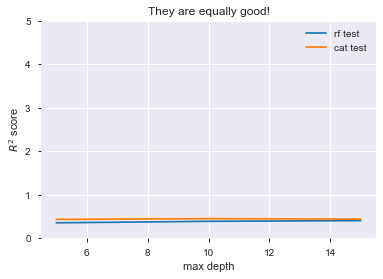

In [39]:
plt.plot(max_depth_values, score_rf_test,  label="rf test")
plt.plot(max_depth_values, score_cat_test,  label="cat test")
plt.xlabel("max depth");
plt.ylabel("$R^2$ score");
plt.ylim(0, 5);
plt.legend();
plt.title("They are equally good!");

The incorrect interpretation that the above visualization is showing is how the graph can be shown so that it seems like the `RandomForstRegressor` is equally good as the `CatBoostRegressor`.

Now let's try to correct the interpretation by fixing this issue:

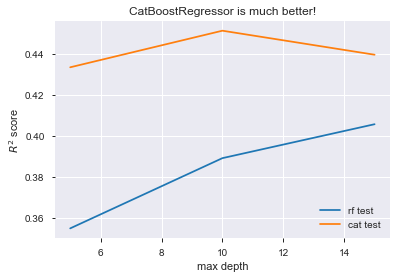

In [40]:
plt.plot(max_depth_values, score_rf_test,  label="rf test")
plt.plot(max_depth_values, score_cat_test,  label="cat test")
plt.xlabel("max depth");
plt.ylabel("$R^2$ score");
plt.legend();
plt.title("CatBoostRegressor is much better!");

To fix the issue, we scaled the graph to a reasonable axis range. Now we can interpret the result differently. The correct interpretation would be: `CatBoostRegressor` has a better score than the `RandomForestRegressor` model.

### END ANSWER

## (optional) Exercise 6

Publish your blog post from Exercise 3 publicly using a tool like Hugo, and paste a link here. Be sure to pick a tool in which code and code output look reasonable. 

Note: this exercise is optional/bonus. If you do it, the grader will add **1 point** to your grade (probably by adding it to some arbitrary question, since I don't think our system handles bonus questions yet). Hopefully the main motivation for you to do this is for your portfolio/resume, not for the 1 point.

## Final sanity check

- Please revisit the **IMPORTANT NOTE** at the top to make sure you have appropriately cited your code.
- Please revisit the **SUBMISSION REQUIREMENT** in Exercise 3 to make sure you have those links in your README.

And that's it, you're done with homework assignments for CPSC 330!